In [1]:
import pandas as pd
import numpy as np
import datetime
import statsmodels as sm
import matplotlib.pyplot as plt
import seaborn as sns 
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.stattools import adfuller, acf, pacf
from sklearn.linear_model import LinearRegression
from statsmodels.tsa.seasonal import seasonal_decompose
from matplotlib.pylab import rcParams
import matplotlib
import folium
import warnings
import matplotlib.ticker as ticker
from sklearn.model_selection import TimeSeriesSplit
import pmdarima as pm
%matplotlib inline

In [2]:
df_raw = pd.read_csv('data/wi_ev_registrations_public.csv')

In [3]:
years = pd.DataFrame(df_raw['Registration Valid Date'].value_counts().reset_index().values, columns=["Year", "Registered Vehicles"])

,Registered Vehicles
Year,
2018-06-30,2791.0
2018-12-31,3575.0
2019-12-31,4211.0
2020-06-30,5166.0
2021-01-01,5788.0
2022-01-01,7589.0


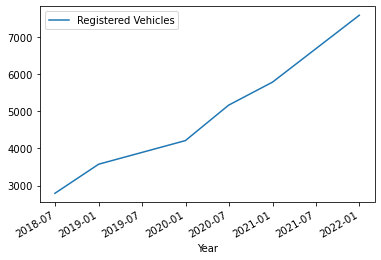

In [4]:
df = pd.DataFrame(years['Registered Vehicles'])
df = df.set_axis(pd.to_datetime(years['Year']))
df.plot()
df = df.sort_values(by=['Year'], ascending = True)
df = df.astype(float)
df

## **RESAMPLING

In [5]:
# # Interpolate - Backfill 
# df = df.resample('W').interpolate(method = 'linear')
# df = df.bfill()
# print(df.head())
# df.plot()

In [6]:
# # Backfill 
# df = df.resample('W').bfill()
# df.plot()

<AxesSubplot:xlabel='Year'>

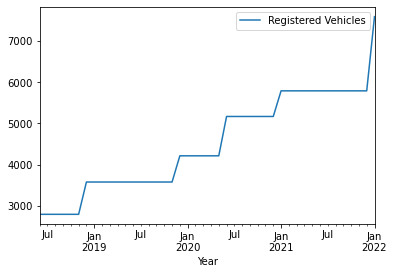

In [7]:
# #Frontfill 
df = df.resample('M').ffill()
df.plot()

## Testing 

In [8]:
adtest = adfuller(df)
display(adtest)

(0.34457450789783256,
 0.9792996161649736,
 0,
 43,
 {'1%': -3.5925042342183704,
  '5%': -2.931549768951162,
  '10%': -2.60406594375338},
 487.42874664022736)

## Modeling

In [17]:
# Splitting Training and Testing data; using after 2019 as test

train = df[:'2021-05']
test = df['2021-06':]
combined = df

test

,Registered Vehicles
Year,
2021-06-30,5788.0
2021-07-31,5788.0
2021-08-31,5788.0
2021-09-30,5788.0
2021-10-31,5788.0
2021-11-30,5788.0
2021-12-31,5788.0
2022-01-31,7589.0


In [18]:
auto_model = pm.auto_arima(train, start_p=0, start_q=0,
                     test='adf',
                     max_p=6, max_q=6,
                     m=1,
                     d=0,
                     seasonal = True,
                     start_P=0,start_Q=0,
                     D=0,
                     trace=True,
                     error_action= 'ignore',
                     suppress_warnings=True,
                     stepwise=True,with_intercept=False)
print(auto_model.summary())



Performing stepwise search to minimize aic
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=706.281, Time=0.02 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=inf, Time=0.03 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=inf, Time=0.04 sec
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=513.507, Time=0.06 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=515.458, Time=0.11 sec
 ARIMA(1,0,2)(0,0,0)[0]             : AIC=515.506, Time=0.09 sec
 ARIMA(0,0,2)(0,0,0)[0]             : AIC=inf, Time=0.05 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=inf, Time=0.05 sec
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=517.453, Time=0.10 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=512.864, Time=0.10 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=570.356, Time=0.06 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=510.871, Time=0.05 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=603.222, Time=0.01 sec
 ARIMA(2,0,0)(0,0,0)[0] intercept   : AIC=512.863, Time=0.10 sec
 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.16 sec

B

### The best model is :  ARIMA (1, 0, 0) (0,0,0) [0]

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.0186      0.030     34.057      0.000       0.960       1.077
sigma2          6e+04   2.15e+04      2.786      0.005    1.78e+04    1.02e+05


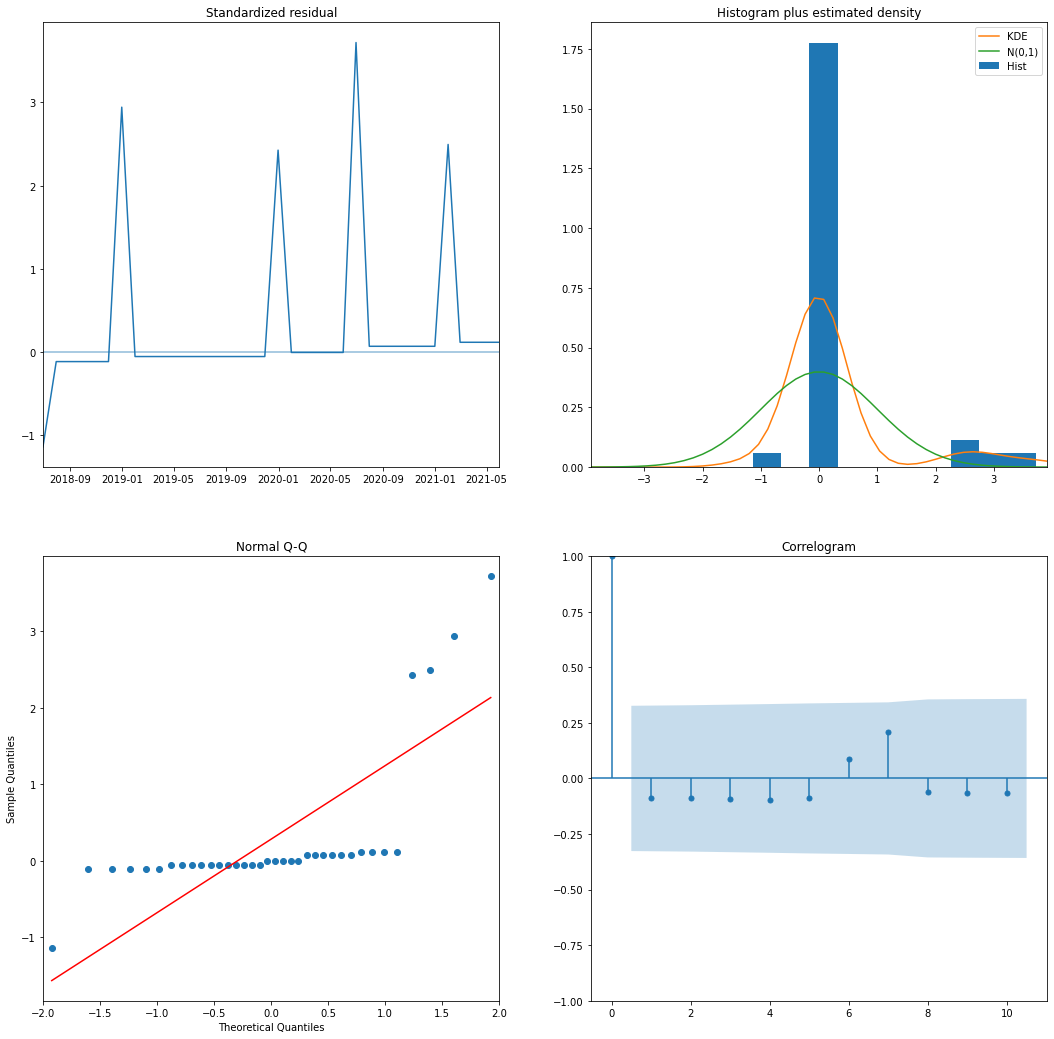

In [19]:
ARIMA_MODEL = sm.tsa.statespace.sarimax.SARIMAX(train, 
                                        order=(1,0,0), 
                                        seasonal_order=(0, 0, 0, 0), 
                                        enforce_stationarity=False, 
                                        enforce_invertibility=False)


output = ARIMA_MODEL.fit()

print(output.summary().tables[1])
auto_model.plot_diagnostics(figsize=(18,18))
plt.show()

In [20]:
pred = output.get_prediction(start=pd.to_datetime('2021-06-30'), end=pd.to_datetime('2022-01-31'), dynamic=False)
pred_conf = pred.conf_int()
pred_conf

,lower Registered Vehicles,upper Registered Vehicles
2021-06-30,5415.831670,6376.007803
2021-07-31,5320.545767,6691.157598
2021-08-31,5270.599354,6965.067360
2021-09-30,5244.326584,7219.479371
2021-10-31,5233.424280,7462.774670
2021-11-30,5233.680604,7699.244407
2021-12-31,5242.622954,7931.441978
2022-01-31,5258.661090,8161.039919


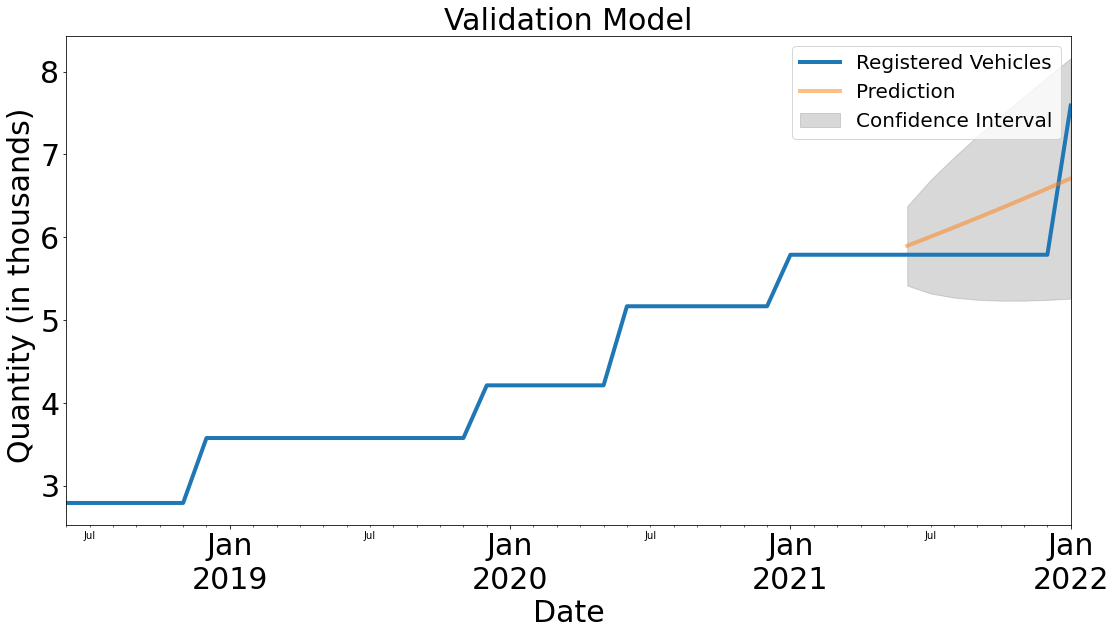

In [21]:


rcParams['figure.figsize'] = 18, 9
ax = df.plot(label='observed', linewidth = 4)

pred.predicted_mean.plot(ax=ax, label='Prediction', alpha=0.5, linewidth = 4)


ax.fill_between(pred_conf.index,
                pred_conf.iloc[:, 0],
                pred_conf.iloc[:, 1], color='grey', alpha=0.3,label = 'Confidence Interval')


ax.set_xlabel('Date',fontsize=30)
plt.xticks(fontsize=30)
ax.set_ylabel('Quantity (in thousands) ',fontsize=30)
plt.yticks(fontsize=30)
scale_y = 1e3
ticks_y = ticker.FuncFormatter(lambda x, pos: '{0:g}'.format(x/scale_y))
ax.yaxis.set_major_formatter(ticks_y)
ax.set_title('Validation Model',fontsize=30)
plt.legend(fontsize = 20)

plt.show()